#Case 6 - Uso de Classificação em uma base de Churn
- Fazer o processo do Crisp-Dm Completo
- Entender os dados
- Ajustar e formatar da melhor maneira
- Encontrar o modelo
- Fazer uso do Tunning para esse modelo e plotar os resultados

In [ ]:
!pip install ydata-profiling

In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ydata_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder, StandardScaler ,MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score


In [260]:
churn = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Classificação/churn_data.xlsx')
churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [261]:
churn_agg = churn.groupby('Churn')['customerID'].count().reset_index()
churn_agg

,Churn,customerID
0,No,5163
1,Yes,1869


<Axes: xlabel='Churn', ylabel='customerID'>

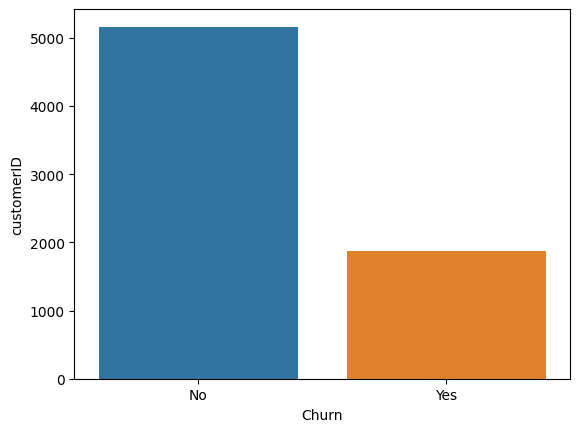

In [262]:
sns.barplot(data= churn_agg, x='Churn', y='customerID')

In [263]:
churn_payment = churn.groupby('PaymentMethod')['customerID'].count().reset_index()
churn_payment

,PaymentMethod,customerID
0,Bank transfer (automatic),1542
1,Credit card (automatic),1521
2,Electronic check,2365
3,Mailed check,1604


<Axes: xlabel='PaymentMethod', ylabel='customerID'>

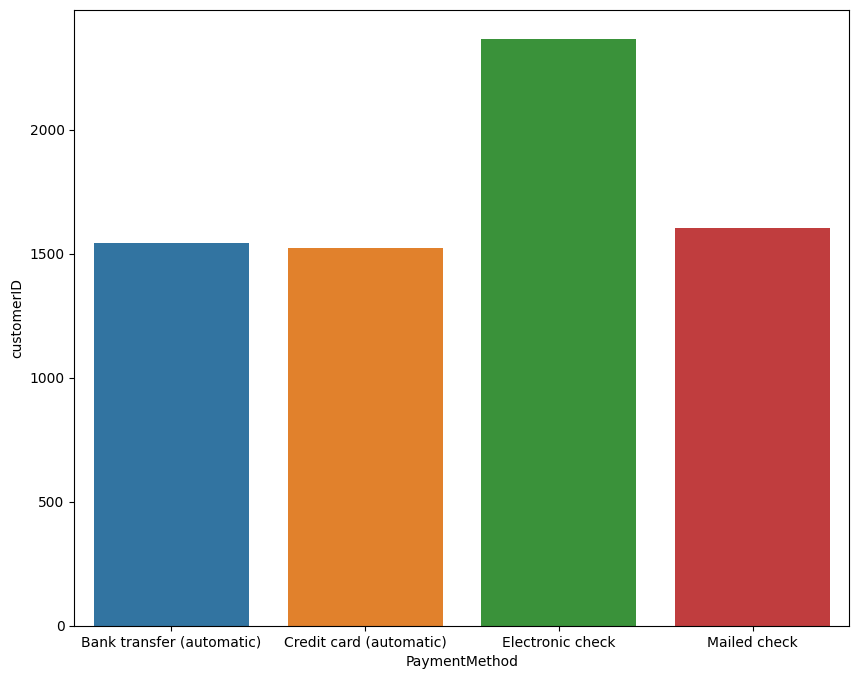

In [264]:
plt.figure(figsize=(10,8))
sns.barplot(data=churn_payment, x='PaymentMethod', y='customerID')
# Claramente vemos que o método mais usado de pagamento é o Electronic check

## Conhecendo os dados - Data Understanding

In [265]:
ProfileReport(df=churn,title="Profiling Report")

Output hidden; open in https://colab.research.google.com to view.

# Preparação dos dados - Data Preparation

In [266]:
# A coluna de CustomerID não nos parece interessar para a analise, por isso vai ser retirada
churn = churn.drop(columns=['customerID'])

In [267]:
churn.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Todas as colunas nos formatos corretos e como deveriam estar

In [268]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [269]:
# Retirando qualquer valor Nulo
churn.dropna(inplace=True)

In [270]:
# Removendo os duplicados

# Identificar valores duplicados
churn[churn.duplicated(keep=False)]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
22,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes
100,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.20,20.20,No
541,Female,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.55,19.55,No
645,Male,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,45.70,45.70,Yes
661,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.05,20.05,No
689,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.45,20.45,No
961,Male,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,45.70,45.70,Yes
973,Male,0,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.90,69.90,Yes
1239,Male,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45.30,45.30,Yes
1334,Male,0,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,Yes


In [271]:
churn.drop_duplicates(inplace=True)

In [272]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7010 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7010 non-null   object 
 1   SeniorCitizen     7010 non-null   int64  
 2   Partner           7010 non-null   object 
 3   Dependents        7010 non-null   object 
 4   tenure            7010 non-null   int64  
 5   PhoneService      7010 non-null   object 
 6   MultipleLines     7010 non-null   object 
 7   InternetService   7010 non-null   object 
 8   OnlineSecurity    7010 non-null   object 
 9   OnlineBackup      7010 non-null   object 
 10  DeviceProtection  7010 non-null   object 
 11  TechSupport       7010 non-null   object 
 12  StreamingTV       7010 non-null   object 
 13  StreamingMovies   7010 non-null   object 
 14  Contract          7010 non-null   object 
 15  PaperlessBilling  7010 non-null   object 
 16  PaymentMethod     7010 non-null   object 


### Ajustando as colunas e sepando o dataset

In [273]:
#Separando os dados
x = churn.drop(columns=['Churn'])

y= churn[['Churn']].copy()

In [274]:
# transformando os dados e retirandos as variáveis categoricas
le = LabelEncoder()

le.fit(y.Churn)
y.Churn = le.transform(y.Churn)


x = pd.get_dummies(data=x)

In [275]:
mm = MinMaxScaler()
x= pd.DataFrame(mm.fit_transform(x))

In [276]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,0.0,0.000000,0.115423,0.001275,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.464789,0.385075,0.215867,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.014085,0.354229,0.010310,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.619718,0.239303,0.210241,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.014085,0.521891,0.015330,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [277]:
y.head()

,Churn
0,0
1,0
2,1
3,0
4,1


### Separando os dados em treino e teste

In [278]:
x_train,x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

# Modelagem de dados - Modeling

Para esse modelo será usado alguns modelos diferentes para tentar chegar a uma previsão cada vez melhor

### Regressão Logistica

In [279]:
from sklearn.linear_model import LogisticRegression


In [280]:
lr = LogisticRegression(penalty='l2', C=1.0)

In [281]:
lr.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [285]:
y_pred_lo = lr.predict(x_test)
y_pred_lo_treino = lr.predict(x_train)

print(f'Acurácia: {accuracy_score(y_test, y_pred_lo)*100}%')
print(f'Acurácia: {accuracy_score(y_train, y_pred_lo_treino)*100}%')
print(f'F1_score: {f1_score(y_test, y_pred_lo)*100}%')
print(f'F1_score: {f1_score(y_train, y_pred_lo_treino)*100}%')

Acurácia: 80.17118402282453%
Acurácia: 80.47432239657631%
F1_score: 59.35672514619882%
F1_score: 59.308807134894096%


In [286]:
x_test.assign(Churn = y_test).assign(label=lr.predict(x_test))

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,Churn,label
5756,0.0,0.535211,0.769154,0.423961,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0
2850,0.0,0.000000,0.633831,0.007287,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,1
2221,0.0,0.126761,0.514925,0.083222,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,1
1399,0.0,0.915493,0.070149,0.190976,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0
1211,0.0,0.746479,0.021393,0.123679,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3809,0.0,0.042254,0.368657,0.025352,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0
3061,0.0,0.718310,0.402985,0.348459,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,0
283,0.0,0.943662,0.360199,0.423373,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4542,0.0,0.098592,0.373134,0.049388,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,0


#### Matrix de confusão

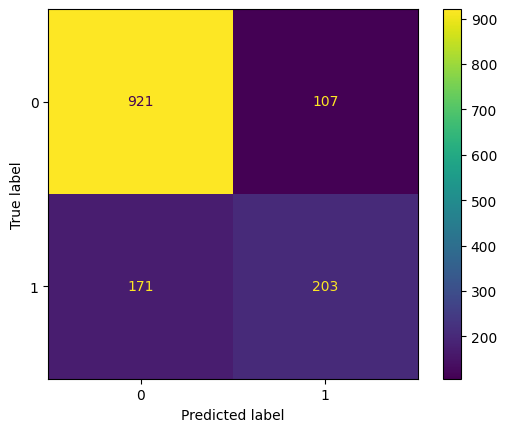

In [287]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm =  confusion_matrix(y_test, y_pred_lo, labels=lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)

disp.plot()

#### Tunning

In [288]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4,5,  9),
    'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(lr, parameters, scoring='accuracy', cv=5, n_jobs=-1)

In [289]:
grid_search.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

In [290]:
grid_search.best_estimator_.get_params()

{'C': 100.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [294]:
lr_tunned = LogisticRegression(
    C= 100.0,
 class_weight= None,
 dual= False,
 fit_intercept= True,
 intercept_scaling= 1,
 l1_ratio= None,
 max_iter= 100,
 multi_class= 'auto',
 n_jobs= None,
 penalty= 'l2',
 random_state= None,
 solver= 'liblinear',
 tol= 0.0001,
 verbose= 0,
 warm_start= False
)

In [295]:
lr_tunned.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=100.0, solver='liblinear')

In [296]:
y_pred_lr_tunned = lr_tunned.predict(x_test)
y_pred_lr_treino_tunned = lr_tunned.predict(x_train)

print(f'Acurácia: {accuracy_score(y_test, y_pred_lr_tunned)*100}%')
print(f'Acurácia: {accuracy_score(y_train, y_pred_lr_treino_tunned)*100}%')
print(f'F1_score: {f1_score(y_test, y_pred_lr_tunned)*100}%')
print(f'F1_score: {f1_score(y_train, y_pred_lr_treino_tunned)*100}%')

Acurácia: 80.17118402282453%
Acurácia: 80.59914407988587%
F1_score: 59.475218658892125%
F1_score: 59.793052475979316%


### Random Forest

In [223]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

In [224]:
rfc.fit(x_train, y_train)

<ipython-input-224-50ce4f6b0dc9>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x_train, y_train)


RandomForestClassifier()

In [231]:
y_pred_test_rfc = rfc.predict(x_test)
y_pred_treino_rfc = rfc.predict(x_train)


print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_rfc)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_treino_rfc)*100}%')
print(f'F1_score Teste: {f1_score(y_test, y_pred_rfc)*100}%')
print(f'F1_score Treino: {f1_score(y_train, y_pred_treino_rfc)*100}%')

# Visto que a metrica a treino e teste tem valores bem distintos, sinais de OVERFIT

Acurácia Teste: 80.17118402282453%
Acurácia Treino: 99.73252496433666%
F1_score Teste: 59.356725146198826%
F1_score Treino: 99.4961370507222%


In [233]:
x_test.assign(Churn = y_test).assign(label=rfc.predict(x_test))

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,Churn,label
2602,0.0,0.183099,0.618905,0.129039,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0
2696,0.0,0.014085,0.578607,0.015347,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,1
632,0.0,0.126761,0.020896,0.018174,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1682,0.0,0.971831,0.789055,0.767396,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0
6639,1.0,0.366197,0.652736,0.264413,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5851,0.0,0.126761,0.819403,0.120171,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,1
6891,0.0,0.732394,0.555721,0.440243,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,0
288,1.0,0.098592,0.559701,0.067823,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
6538,0.0,0.056338,0.017910,0.008856,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0


#### Matrix de confusão

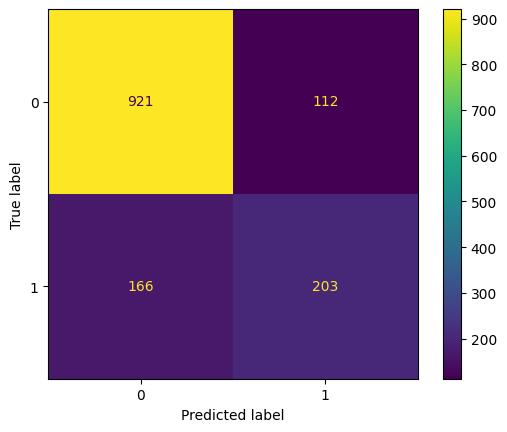

In [227]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm =  confusion_matrix(y_test, y_pred_rfc, labels=rfc.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)

disp.plot()

#### Tunning

In [234]:
parameters = {
    'n_estimators':[100,300,500],
    'max_depth':[1,2,3,4,5,6,7,8,9,10]
}

grid_search = GridSearchCV(rfc, parameters, scoring='accuracy', cv=5, n_jobs=-1)

In [239]:
grid_search.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

In [242]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [248]:
rfc_tunned = RandomForestClassifier(
bootstrap= True,
 ccp_alpha= 0.0,
 class_weight= None,
 criterion= 'gini',
 max_depth= 8,
 max_features= 'sqrt',
 max_leaf_nodes= None,
 max_samples= None,
 min_impurity_decrease= 0.0,
 min_samples_leaf= 1,
 min_samples_split= 2,
 min_weight_fraction_leaf= 0.0,
 n_estimators= 100,
 n_jobs= None,
 oob_score= False,
 random_state= None,
 verbose= 0,
 warm_start= False
)

In [249]:
rfc_tunned.fit(x_train,y_train)

<ipython-input-249-ad6dea014403>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_tunned.fit(x_train,y_train)


RandomForestClassifier(max_depth=8)

In [250]:
y_pred_test_rfc_tunned = rfc_tunned.predict(x_test)
y_pred_treino_rfc_tunned = rfc_tunned.predict(x_train)


print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_test_rfc_tunned)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_treino_rfc_tunned)*100}%')
print(f'F1_score Teste: {f1_score(y_test, y_pred_test_rfc_tunned)*100}%')
print(f'F1_score Treino: {f1_score(y_train, y_pred_treino_rfc_tunned)*100}%')

# Uma analise muito melhor e mais confiável

Acurácia Teste: 80.81312410841655%
Acurácia Treino: 83.16690442225392%
F1_score Teste: 58.678955453149015%
F1_score Treino: 64.26949280847842%


### Arvore de decisão

In [78]:
from sklearn.tree import DecisionTreeClassifier

In [79]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)

DecisionTreeClassifier()

In [80]:
y_pred_tree = dtc.predict(x_test)
y_pred_tree_train = dtc.predict(x_test)


print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_tree)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_tree_train)*100}%')
print(f'F1_score Teste: {f1_score(y_test, y_pred_tree)*100}%')
print(f'F1_score Treino: {f1_score(y_train, y_pred_tree_train)*100}%')

Acurácia: 73.2524964336662%
F1_score: 51.23537061118335%


### KNN

In [81]:
from sklearn.neighbors import KNeighborsClassifier

In [83]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [85]:
y_pred_knn = knn.predict(x_test)
y_pred_knn_train = knn.predict(x_train)

print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_knn)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_knn_train)*100}%')
print(f'F1_score Teste: {f1_score(y_test, y_pred_knn)*100}%')
print(f'F1_score Teino: {f1_score(y_train, y_pred_knn_train)*100}%')

Acurácia: 76.53352353780313%
F1_score: 54.86968449931414%


### SVM

In [86]:
from sklearn.svm import SVC

In [88]:
svc = SVC()
svc.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [89]:
y_pred_svc = svc.predict(x_test)
y_pred_svc_train = svc.predict(x_train)

print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_svc)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_svc_train)*100}%')
print(f'F1_score Teste: {f1_score(y_test, y_pred_svc)*100}%')
print(f'F1_score Treino: {f1_score(y_train, y_pred_svc_train)*100}%')

Acurácia: 78.9586305278174%
F1_score: 55.5052790346908%


### Redes Neurais

In [297]:
from sklearn.neural_network import MLPClassifier

In [298]:
clf = MLPClassifier(hidden_layer_sizes=(100,50,20), activation='logistic')

In [299]:
clf.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50, 20))

In [301]:
y_pred_clf = clf.predict(x_test)
y_pred_clf_train = clf.predict(x_train)

print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_clf)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_clf_train)*100}%')
print(f'F1_score Teste: {f1_score(y_test, y_pred_clf)*100}%')
print(f'F1_score Treino: {f1_score(y_train, y_pred_clf_train)*100}%')

Acurácia Teste: 79.81455064194009%
Acurácia Treino: 80.84878744650499%
F1_score Teste: 56.79389312977099%
F1_score Treino: 58.97631779984721%


#### Tunning

In [302]:
parameters = {
    'hidden_layer_sizes': [(100), (50, 50), (30, 20, 10)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

grid_search = GridSearchCV(clf, parameters, scoring='accuracy', cv=5, n_jobs=-1)

In [303]:
grid_search.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic',
                                     hidden_layer_sizes=(100, 50, 20)),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100,), (50, 50),
                                                (30, 20, 10)]},
             scoring='accuracy')

In [305]:
grid_search.best_estimator_.get_params()

{'activation': 'tanh',
 'alpha': 0.01,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [306]:
clf_tunned = MLPClassifier(
activation= 'tanh',
 alpha= 0.01,
 batch_size= 'auto',
 beta_1= 0.9,
 beta_2= 0.999,
 early_stopping= False,
 epsilon= 1e-08,
 hidden_layer_sizes= (100,),
 learning_rate= 'constant',
 learning_rate_init= 0.001,
 max_fun= 15000,
 max_iter= 200,
 momentum= 0.9,
 n_iter_no_change= 10,
 nesterovs_momentum= True,
 power_t= 0.5,
 random_state= None,
 shuffle= True,
 solver= 'adam',
 tol= 0.0001,
 validation_fraction= 0.1,
 verbose= False,
 warm_start= False
)

In [307]:
clf_tunned.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='tanh', alpha=0.01)

In [308]:
y_pred_clf_test_tunned = clf_tunned.predict(x_test)
y_pred_clf_train_tunned = clf_tunned.predict(x_train)

print(f'Acurácia Teste: {accuracy_score(y_test, y_pred_clf_test_tunned)*100}%')
print(f'Acurácia Treino: {accuracy_score(y_train, y_pred_clf_train_tunned)*100}%')
print(f'F1_score Teste: {f1_score(y_test, y_pred_clf_test_tunned)*100}%')
print(f'F1_score Treino: {f1_score(y_train, y_pred_clf_train_tunned)*100}%')

Acurácia Teste: 80.31383737517832%
Acurácia Treino: 80.95577746077034%
F1_score Teste: 60.0%
F1_score Treino: 60.85043988269794%
